# Notebook to demonstrate the mu(z,k) with screening parameters phenomenological model

In [2]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

In [3]:
Omega_c = 0.25
Omega_b = 0.05
h = 0.7
n_s = 0.97
A_s = 2.1e-9
m_nu = 0.0

In [4]:
# Run CAMB to get linear spectrum 

p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False)
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=-1,wa=0.0)

p.set_matter_power(redshifts=np.linspace(0.0, 10.0, 64, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)

r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=128)

Omega_v = r.omega_de + r.get_Omega("photon") + r.get_Omega("neutrino")
Omega_m = p.omegam

# DESI priors on DE and mu(k,z) model considered here https://arxiv.org/pdf/2411.12026 

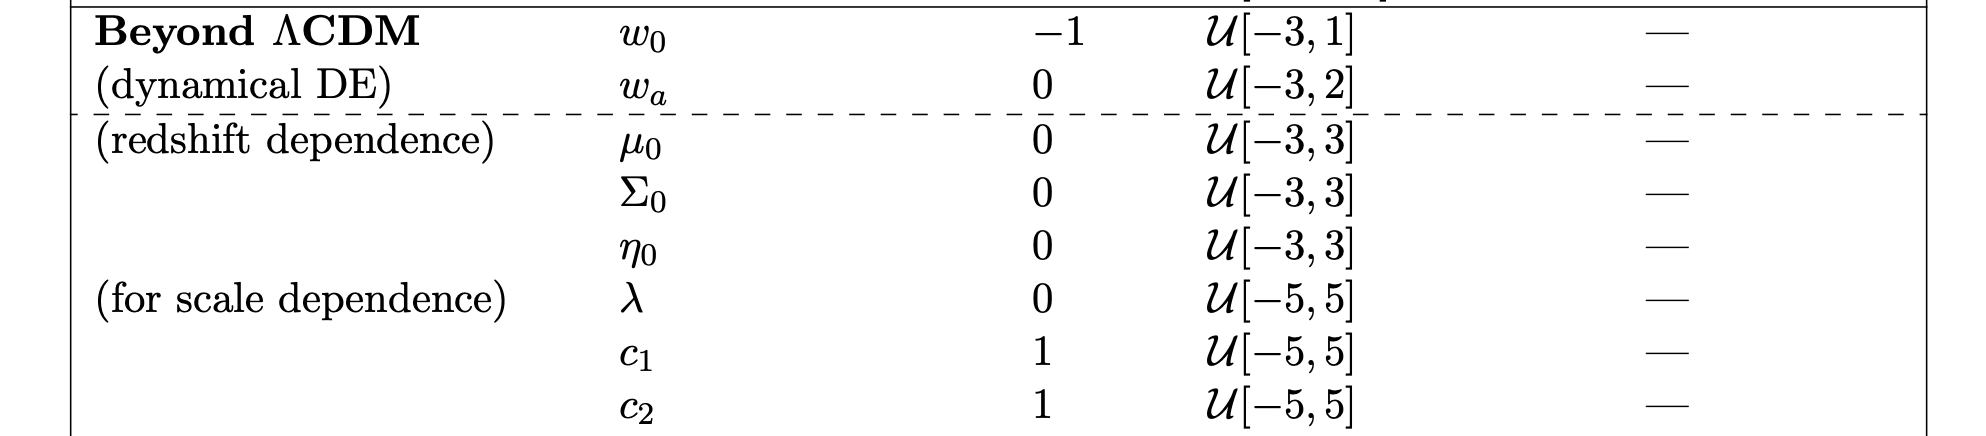

# Some limits for nonlinear parameters (https://arxiv.org/pdf/2210.01094)  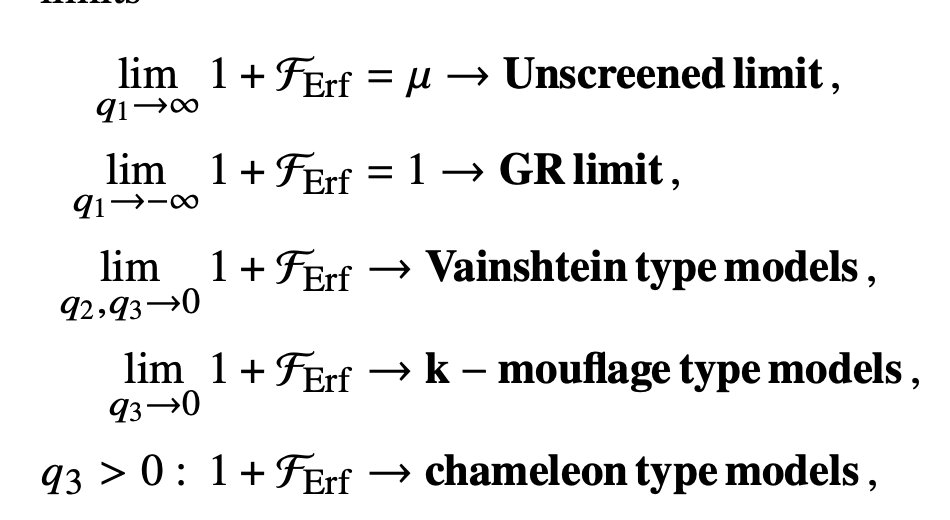

In [60]:
# Select model
mymodel = "muscreened"
massloop = 30

# Extra parameters (see https://arxiv.org/abs/2210.01094 and https://arxiv.org/pdf/2411.12026) 
# Fiducial values to test variations around 
w0 = [-0.9,-1,-1.1] 
wa = [-0.1,0.,0.1]
mu0 = [-1., 0., 1] 
c2 = [-1., 0., 1.]
lam = [-1.,0.,1.]
q1 = [-2.0, 0., 2]
q2 = [-2, 0., 2]
q3 = [-2, 0., 2] 

# Doesn't have much of an effect (keep 0) 
q4 = [-2., 0., 2.] 


myind = 1

extrapars = np.zeros(20)
extrapars[0] = w0[myind]
extrapars[1] = wa[myind]
extrapars[2] = mu0[myind]
extrapars[3] = c2[myind]
extrapars[4] = lam[myind]
extrapars[5] = q1[myind]
extrapars[6] = q2[myind]
extrapars[7] = q3[myind]
extrapars[8] = q4[myind]

In [62]:
# Run ReACT
react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
z_react = z_lin[z_lin < 2.5]

R, pofk_lin_MG_react, sigma_8_mg, pseudo = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodel, 
                                extrapars, 
                                compute_pseudo=True,
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  

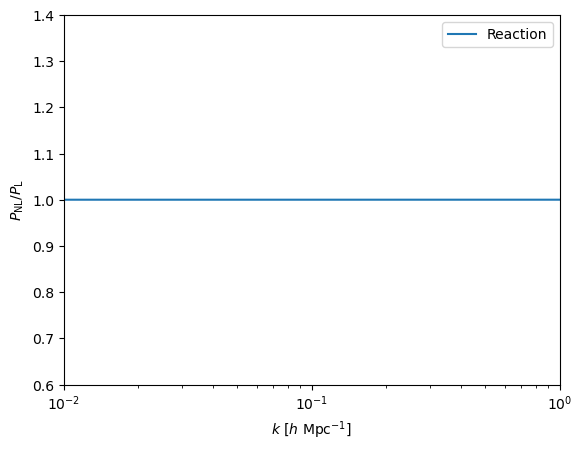

In [68]:
# Plot the reaction 

plt.semilogx(k_lin, R[0] ,linestyle='solid',label='Reaction')

plt.xlim([0.01,1])
plt.ylim([0.6,1.4])

plt.ylabel("$P_{\\rm NL}/P_{\\rm L}$")
plt.xlabel("$k$ [$h$ Mpc$^{-1}$]")


plt.legend()
plt.show()

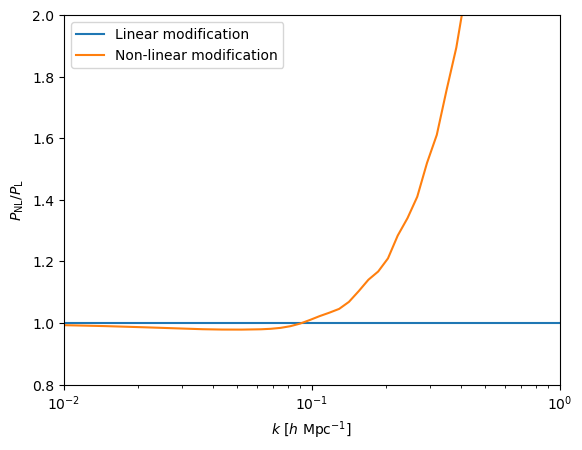

In [63]:
# Plot the spectra 

plt.semilogx(k_lin, pofk_lin_MG_react[0]/pofk_lin_camb[0] ,linestyle='solid',label='Linear modification')
plt.semilogx(k_lin, R[0]*pseudo[0]/pofk_lin_camb[0] ,linestyle='solid',label='Non-linear modification')

plt.xlim([0.01,1])
plt.ylim([0.8,2])

plt.ylabel("$P_{\\rm NL}/P_{\\rm L}$")
plt.xlabel("$k$ [$h$ Mpc$^{-1}$]")


plt.legend()
plt.show()